In [2]:
#imports here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from PIL import Image, ImageOps, ImageEnhance
import os
import re
import torch.optim as optim
from torch.autograd import Variable
#!pip3 install kornia
from kornia.color import RgbToGrayscale
from sklearn.model_selection import train_test_split
import math
print('Imports Done')

c:\Users\thire\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Imports Done


The early stopping class is from here this github, and the credit goes to him. I only use it for early stopping. https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Below is for plotting each image in R, G ,B

In [4]:
os.chdir(os.getcwd())

In [5]:
def load_images(folder_path):
    image_array = []
    
    # List all files in the folder
    file_list = os.listdir(folder_path)
    
    # Filter only TIFF files
    tiff_files = [file for file in file_list if file.lower().endswith('.tif') or file.lower().endswith('.tiff')]
    gif_files = [file for file in file_list if file.lower().endswith('.gif')]
    # Load each TIFF image and store it in the array
    if len(tiff_files) > 0:
        print('Getting tiff files')
        for file in tiff_files:
            file_path = os.path.join(folder_path, file)
            try:
                # Open TIFF image using PIL
                img = Image.open(file_path)
                
                # Convert PIL Image to numpy array
                img_array = np.array(img)
                
                # Append to the image array
                image_array.append(img_array)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    if len(gif_files) > 0:
        print('Getting gif files')
         # Load GIF images
        for file in gif_files:
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path)
                img_array = np.array(img)
                image_array.append(img_array)
            except Exception as e:
                print(f"Error loading {file}: {e}")

    return np.asarray(image_array)
XtrainPath = os.getcwd() + '/Data/DRIVE/training/images'
#XtrainPath = os.getcwd() + '/Data2/Train'
#X_Train = load_images(XtrainPath)
Train_img = load_images(XtrainPath)
YtrainPath = os.getcwd() + '/Data/DRIVE/training/1st_manual'
#YtrainPath = os.getcwd() + '/Data2/TrainLabel'
Label_img = load_images(YtrainPath)

Getting tiff files
Getting gif files


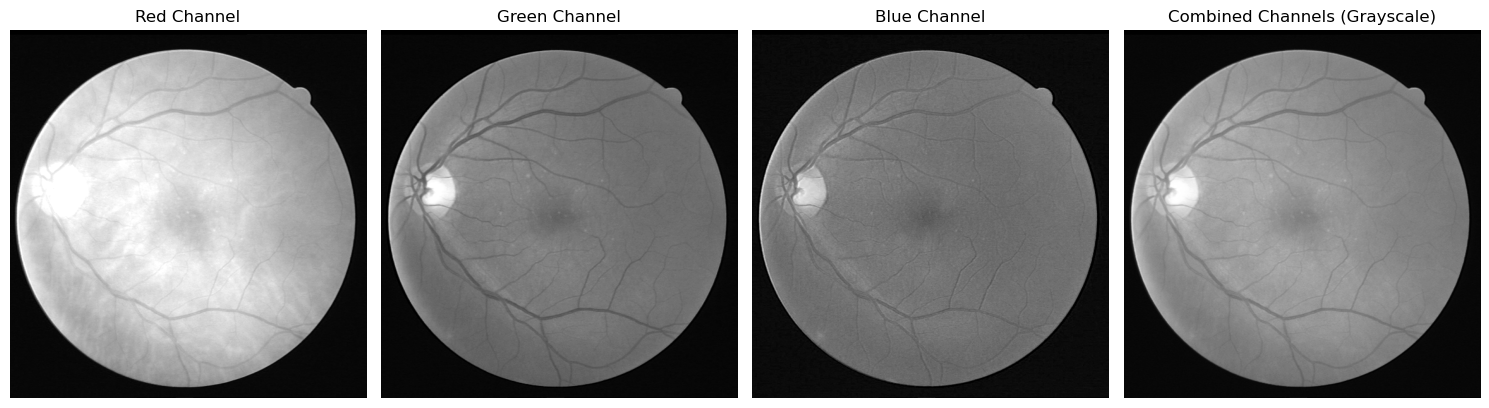

In [20]:
# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
#color = 'CMRmap'
color = 'gray'
# Display each channel in grayscale in a separate subplot
axs[0].imshow(Train_img[0][:, :, 0], cmap=color)
axs[0].set_title('Red Channel')
axs[0].axis('off')

axs[1].imshow(Train_img[0][:, :, 1], cmap=color)
axs[1].set_title('Green Channel')
axs[1].axis('off')

axs[2].imshow(Train_img[0][:, :, 2], cmap=color)
axs[2].set_title('Blue Channel')
axs[2].axis('off')

combined_channels_gray = 0.299 * Train_img[0][:, :, 0] + 0.587 * Train_img[0][:, :, 1] + 0.114 * Train_img[0][:, :, 2]
axs[3].imshow(combined_channels_gray, cmap=color)
axs[3].set_title('Combined Channels (Grayscale)')
axs[3].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Save or display the plot
output_dir = f'{os.getcwd()}/OutPut'
os.makedirs(output_dir, exist_ok=True)
output_path = f'{output_dir}/Original_Row_Grayscale.png'

plt.savefig(output_path, dpi=400, bbox_inches='tight')
plt.show()


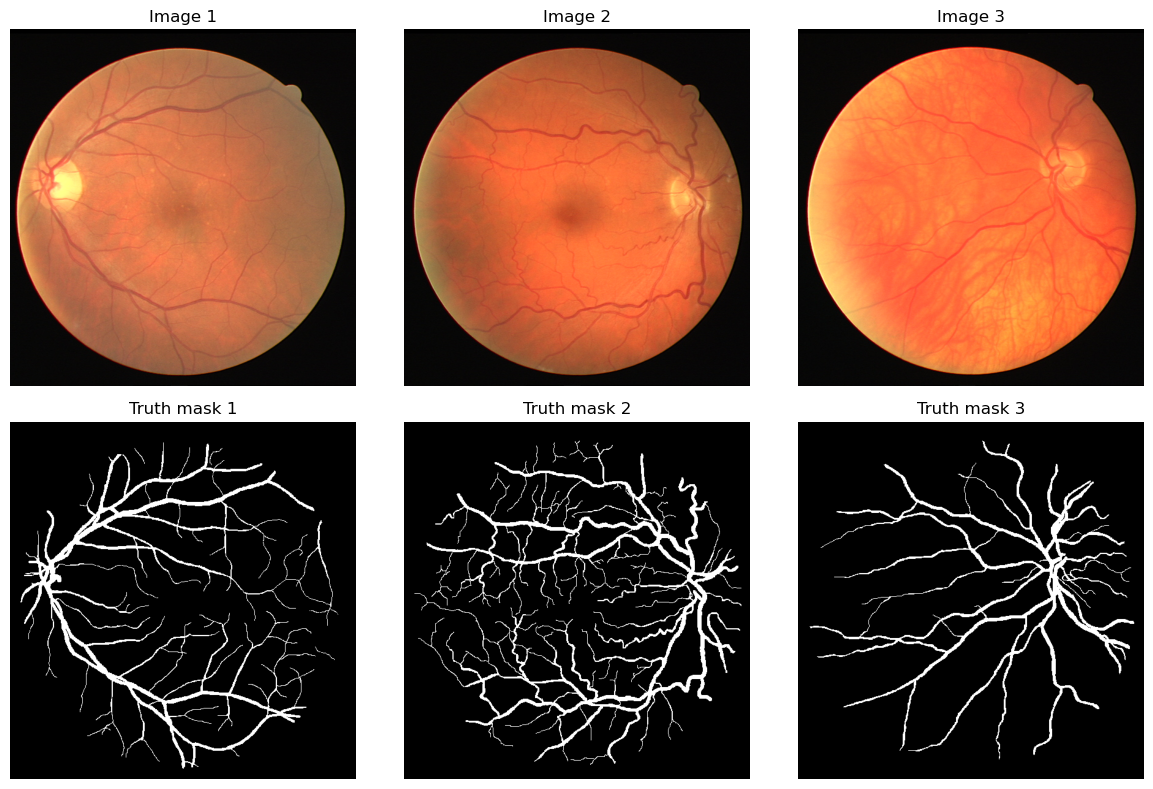

In [25]:
# Create a subplot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate through the images and plot them
for i in range(3):
    axs[0][i].imshow(Train_img[i], cmap='gray')  # Replace 'gray' with the desired colormap
    axs[0][i].set_title(f'Image {i + 1}')
    axs[1][i].imshow(Label_img[i], cmap='gray')  # Replace 'gray' with the desired colormap
    axs[1][i].set_title(f'Truth mask {i + 1}')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
# Adjust layout for better spacing
plt.tight_layout()
output_path = f'{output_dir}/SampleTrainImages.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')
# Show the plot
plt.show()

# DL

## Below is from the BA project, With UNet


In [7]:
#unet implementation here
#Form the Bachelor project
#This is for each "block", each block does the convolutional step
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding= 1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding= 1)
        self.BN    = nn.BatchNorm2d(out_ch, affine=False)
        self.Drop  = nn.Dropout(0.01)

    def forward(self, x):
        return self.relu( self.Drop(self.BN (self.conv2( self.relu( self.Drop( self.BN( self.conv1(x) ) ) ) ))))

#This is the downsampling step/ the encoding step.
class Encoder(nn.Module):
    def __init__(self, chs=(1, 8, 16, 32, 64, 128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, input):
        features = []
        for block in self.enc_blocks:
            input = block(input)
            features.append(input)
            input = self.pool(input)
        return features

#This is the decoder, or where we upsample again, / putting everything together
class Decoder(nn.Module):
    def __init__(self, chs=(128, 64, 32, 16, 8)):
        super().__init__()
        self.chs         = chs
        self.up    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, padding=0) for i in range(len(chs)-1)]) #maybe use torch unpool "max unpool 2D"
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, Input, encoder_features):
        for i in range(len(self.chs)-1):
            Input        = self.up[i](Input)
            enc_ftrs = self.crop(encoder_features[i], Input)
            Input        = torch.cat([Input, enc_ftrs], dim=1)
            Input        = self.dec_blocks[i](Input)
        return Input

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

#The final UNet Call
class UNet(nn.Module):
    def __init__(self, enc_chs=(1, 8, 16, 32, 64, 128), dec_chs=(128, 64, 32, 16, 8), num_class=1): #Change num_class to handle 4 channels
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.sig         = nn.Sigmoid() #clamps the output to between 1 and 0
        self.num_class   = num_class #think of it as the number of object classes to segment

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        out      = self.sig(out) #bad with a activation function as last layer? is the data normalized?
        out = F.interpolate(out, (x.shape[2], x.shape[3]), mode = 'nearest')
        return out

In [8]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()

    def forward(self, pred, target):
        smooth = 1. # added smooth to avoid division by zero, if foreground contains no value
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
'''
Config
----------------------------------------------------------------------------
'''
Epoch = 200
Learning_rate = 0.01
momentum = 0.9 #only for SGD optimizer
#Loss = nn.BCELoss()
Loss = diceloss() #Diceloss better for small details CURRENT OUTPUT IS FOR BCELOSS
Optimizer = optim.Adam
Delta = 0.001
Patience = 10
'''
----------------------------------------------------------------------------
'''

def SwApAxis(Arr_Img, channel, Grayscale):
    '''
    Swaps axies such that we have. (now also supports selecting RGB channel)
    WxHxC
    instead of
    CxWxH
    also adds a dimension for the unet implementation and converts it to a torch
    '''
    gray = RgbToGrayscale()
    temp_Arr = []
    if (Grayscale == True):
        for img in Arr_Img:
            img = np.asarray(img, dtype = np.float32)
            img /= 255.0
            temp = np.swapaxes(img, 0,-1)
            temp1 = np.asarray(np.swapaxes(temp, 1, -1))
            temp_Arr.append(temp1)
        return gray(torch.from_numpy(np.asarray(temp_Arr)))

    if ((channel == 0) or (channel == 1) or (channel == 2) ):
        for img in Arr_Img:
            img = np.asarray([img[:][:,:,channel]], dtype= np.float32)
            img /= 255.0
            temp_Arr.append(img)
 #       plt.imshow(temp_Arr[0][0])
 #       plt.show()
        return torch.from_numpy(np.asarray(temp_Arr))
    else:
        for img in Arr_Img:
            img = np.asarray(img, dtype= np.float32)
            img /= 255.0
            temp = np.swapaxes(img,0,-1)
            temp1 = np.asarray(np.swapaxes(temp, 1, -1))
            temp_Arr.append(temp1)
        return (torch.from_numpy(np.asarray(temp_Arr))) #Redoes the Colors to gray-scale
new_train = SwApAxis(Train_img, 1, Grayscale = True)

def Normalize_labels(Labels):
    new_arr = []
    for i in range(np.asarray(Label_img).shape[0]):
        temp = np.asarray(Label_img[i], dtype= float)
        temp /= 255.0
        new_arr.append(temp)
    return new_arr
New_Label_img = Normalize_labels(Label_img)

#new_Test_img = SwApAxis(Test_img, 1, True)


## Training loop


In [9]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(new_train, New_Label_img, test_size = 0.3, shuffle = False) # random state is nice, but can't check with output after, maybe for testing it would be nice
print('X_train shape: ', X_Train.shape,
    '\nY_train shape: ', len(Y_Train),
    '\nX_Val shape: ', X_Val.shape,
    '\nY_Val shape: ',len( Y_Val))

X_train shape:  torch.Size([14, 1, 584, 565]) 
Y_train shape:  14 
X_Val shape:  torch.Size([6, 1, 584, 565]) 
Y_Val shape:  6


In [29]:
def Evalf(model, loss, X_val, Y_val):
    '''
    Takes current epoch model, Trains the X_val data on it
    Returns the Loss output from the given "loss" function.
    '''
    out = model(X_val)
    loss_out = loss(out, Y_val)
    return loss_out.item()

def Evalf_Test(model, X_test):
    out = model(X_test)
    for i in range(out.shape[0]):
        temp = np.asarray(out[i].cpu().detach().numpy())
        temp = temp[0]
        im = Image.fromarray((temp*255).astype(np.uint8))
        #im = im.save(f'/content/drive/My Drive/EML/Output/DiceLoss/Test_out/{i+1}_test.tif')

def Train_loop(X_Train, Y_Train, X_Val, Y_Val, model, epochs, lr, OP, loss_Function, patience, delta):
    print('Choosen Model: ','UNet',
    '\nNumber of Epoch: ' + str(epochs),
    '\nOptimizer: ' + str(OP),
    '\nLearning rate: ' + str(lr),
    '\nLoss function: ' + str(loss_Function)+ '\n'
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    if device == 'cpu':
        print('Not gonna run on the CPU ¯\_(ツ)_/¯')
        return None, None, None
    Train_loss = []
    optimizer = OP(model.parameters(), lr = lr)
    #optimizer = optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    loss_function = loss_Function
    total_losses = []

    #To get labels into the correct shape

    model.to(device)
    Validation = []
    Val_loss = []
    early_stopping = EarlyStopping( patience=patience, verbose=True, delta = delta)

    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        out = model(X_Train.to(device))
        loss = loss_function(out, torch.tensor(Y_Train).float().to(device))
        loss.backward()
        optimizer.step()
        total_losses.append(loss.item())
        running_loss = loss.item() # each epoch loss

        temp = Evalf(model, loss_function, X_Val.to(device), torch.tensor(Y_Val).float().to(device))
        Validation.append(temp)

        print('Current Epoch:', epoch, 'Train loss for this epoch', (running_loss))
        early_stopping(temp, model)

        if early_stopping.early_stop:
            print("Early stopping ---------- Epoch: ", epoch)
            break
        else:
            continue

    return total_losses, Validation, out


model = UNet(enc_chs=(1, 8, 16, 32, 64, 128), dec_chs=(128, 64, 32, 16, 8), num_class = 1)
Loss, Validation, out = Train_loop(X_Train
                                   , Y_Train
                                   , X_Val
                                   ,Y_Val
                                   , model
                                   , epochs = Epoch, lr = Learning_rate, OP = Optimizer, loss_Function = Loss, patience = Patience, delta = Delta)

print('done')


X_train shape:  torch.Size([12, 1, 584, 565]) 
Y_train shape:  12 
X_Val shape:  torch.Size([8, 1, 584, 565]) 
Y_Val shape:  8
Choosen Model:  UNet 
Number of Epoch: 200 
Optimizer: <class 'torch.optim.adam.Adam'> 
Learning rate: 0.01 
Loss function: diceloss()

cuda:0


C:\Users\thire\AppData\Local\Temp\ipykernel_4776\4194965139.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  loss = loss_function(out, torch.tensor(Y_Train).float().to(device))


Current Epoch: 0 Train loss for this epoch 0.7427835464477539
Validation loss decreased (inf --> 0.702448).  Saving model ...
Current Epoch: 1 Train loss for this epoch 0.7119715213775635
Validation loss decreased (0.702448 --> 0.689649).  Saving model ...
Current Epoch: 2 Train loss for this epoch 0.6996585726737976
Validation loss decreased (0.689649 --> 0.681934).  Saving model ...
Current Epoch: 3 Train loss for this epoch 0.6927143335342407
Validation loss decreased (0.681934 --> 0.676545).  Saving model ...
Current Epoch: 4 Train loss for this epoch 0.6872969269752502
Validation loss decreased (0.676545 --> 0.669435).  Saving model ...
Current Epoch: 5 Train loss for this epoch 0.6801978349685669
Validation loss decreased (0.669435 --> 0.662381).  Saving model ...
Current Epoch: 6 Train loss for this epoch 0.671484649181366
Validation loss decreased (0.662381 --> 0.654599).  Saving model ...
Current Epoch: 7 Train loss for this epoch 0.6652258634567261
Validation loss decreased (

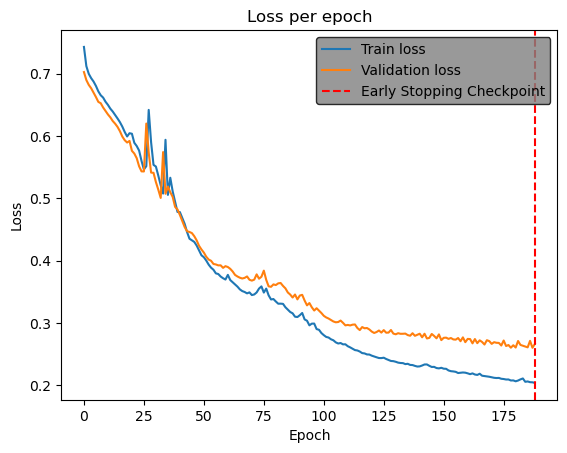

Last Train loss:  0.2037675380706787 
Last Val loss:  0.26625651121139526


In [31]:
X_axis = []
for i in range (len(Loss)):
    X_axis.append(i)

plt.plot(X_axis, Loss, label = 'Train loss')
plt.plot(X_axis, Validation, label = 'Validation loss')
minposs = Validation.index(min(Validation))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
legend = plt.legend(loc = 'upper right', frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('grey')
frame.set_edgecolor('black')
plt.xlabel ('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
#plt.savefig(f'/content/drive/My Drive/EML/Output/Validation_eproch'+str(Epoch)+'LR'+str(Learning_rate)+'D0_001_MinLoss1902.png', dpi = 400)
plt.show()
print('Last Train loss: ', Loss[-1],'\n'
        'Last Val loss: ', Validation[-1])

# Clustering

In [10]:
data = X_Val.detach().cpu().numpy()[0][0]
#data = data.reshape(-1, 1)  # Reshape the image into a column vector
print(data.shape)

(584, 565)


Best solution is [0.76001793 0.46035258 0.60457573 0.53226206 0.04088121]
Fitness of the best solution is 0.00015911936900307052
Best solution found after 97 generations


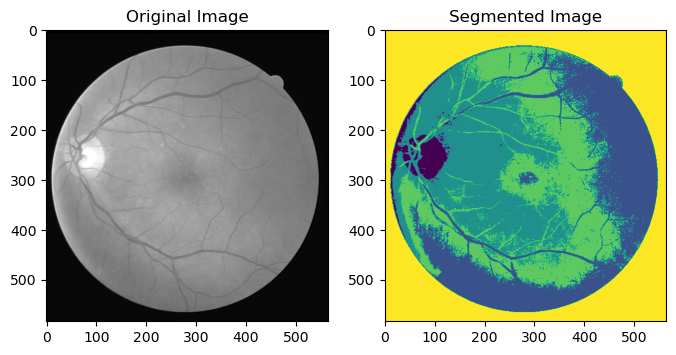

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pygad


image = X_Train.detach().cpu().numpy()[0][0]
# Flatten the image matrix
image_flat = image.flatten().reshape(-1, 1)

# Define the number of clusters (segments)
num_segments = 5
crossover = True
mutation = True

fitness_lst = []

def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X - Y, 2), axis=1))

def segment_data(solution, solution_idx):
    global num_segments, image
    pixel_value_length = image_flat.shape[1]
    segment_centers = []
    all_segments_dists = []
    segments = []
    segments_sum_dist = []

    for seg_idx in range(num_segments):
        segment_centers.append(solution[pixel_value_length * seg_idx:pixel_value_length * (seg_idx + 1)])
        segment_center_dists = euclidean_distance(image_flat, segment_centers[seg_idx])
        all_segments_dists.append(np.array(segment_center_dists))

    segment_centers = np.array(segment_centers)
    all_segments_dists = np.array(all_segments_dists)

    segment_indices = np.argmin(all_segments_dists, axis=0)
    for seg_idx in range(num_segments):
        segments.append(np.where(segment_indices == seg_idx)[0])
        if len(segments[seg_idx]) == 0:
            segments_sum_dist.append(0)
        else:
            segments_sum_dist.append(np.sum(all_segments_dists[seg_idx, segments[seg_idx]]))

    segments_sum_dist = np.array(segments_sum_dist)

    return segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist

def fitness_func(_, solution, solution_idx):
    _, _, _, _, segments_sum_dist = segment_data(solution, solution_idx)

    fitness = 1.0 / (np.sum(segments_sum_dist) + 0.00000001)
    fitness_lst.append(fitness)
    #best_solution_fitness = ga_instance.best_solution()[1]
    # custom implementation to record fitness
    # print(ga_instance.generations_completed)
    # if ga_instance.generations_completed > len(fitness_lst):
    #    fitness_lst.append(best_solution_fitness)
    return fitness

num_genes = num_segments * image_flat.shape[1]

if crossover:
    CrossOver = "single_point"
    crossover_probability = 0.5
else:
    CrossOver = None
    crossover_probability = None

if mutation:
    Mutation = "random"
    mutation_percent_genes = 10
else:
    Mutation = None
    mutation_percent_genes = None


ga_instance = pygad.GA(num_generations=100
                       ,sol_per_pop=10
                       ,num_parents_mating=5
                       #,init_range_low=0
                       #,init_range_high=1
                       ,crossover_type = CrossOver
                       ,crossover_probability = crossover_probability
                       ,keep_parents=2
                       ,num_genes=num_genes
                       ,fitness_func=fitness_func
                       ,suppress_warnings=True
                       , mutation_percent_genes=mutation_percent_genes
                       , mutation_type = Mutation
                       , mutation_probability = 0.5)

ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist = segment_data(best_solution, best_solution_idx)

# Reshape the segmented image to its original shape
final_segmentation = np.zeros_like(image)
for seg_idx in range(num_segments):
    final_segmentation.flat[segments[seg_idx]] = seg_idx + 1

# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(final_segmentation, cmap='viridis')
plt.title('Segmented Image')
plt.show()


Note that we are interested in minimizing the sum of squares. so lower is better. However there might be some false positives/negatives here which makes the data

903


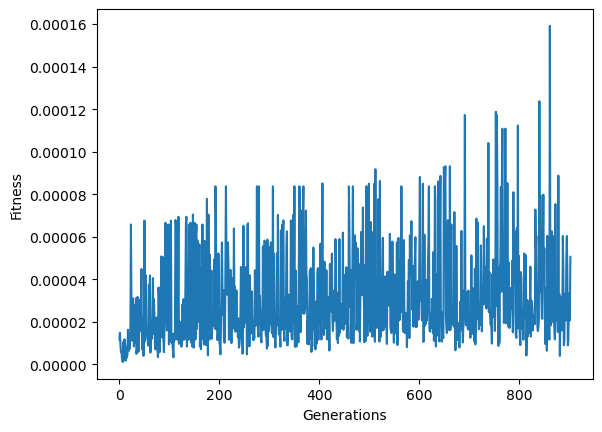

In [12]:
print(len(fitness_lst))
plt.plot(range(len(fitness_lst)), fitness_lst)
plt.ylabel('Fitness')
plt.xlabel('Generations')
plt.show()

In [13]:
print(final_segmentation[300][0:500])

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3.
 3. 4. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4.
 3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 2.
 2. 4. 2. 4. 4. 4. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 2. 2. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4.

5 0
5 1
5 2
5 3
5 4


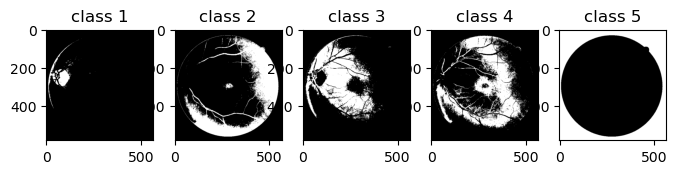

In [15]:
plt.figure(figsize=(8, 4))
for i in range(num_segments):
    print(num_segments, i)
    temp1 = final_segmentation == i+1
    plt.subplot(1, num_segments, i+1)
    plt.imshow(temp1, cmap='gray')
    plt.title(f'class {i+1}')
# temp2 = final_segmentation == 3
# plt.subplot(1, 3, 2)
# plt.imshow(temp2, cmap='gray')
# plt.title('temp2')
# plt.show()
# temp3 = final_segmentation == 2
# plt.subplot(1, 3, 3)
# plt.imshow(temp3, cmap='gray')
plt.show()

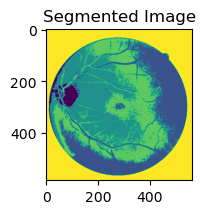

In [16]:
temp3 = final_segmentation < best_solution[2]
plt.subplot(1, 3, 2)
plt.imshow(final_segmentation, cmap='viridis')
plt.title('Segmented Image')
plt.show()

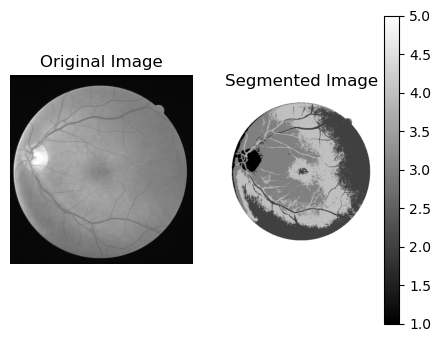

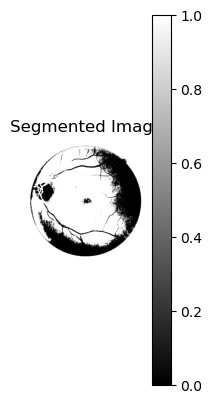

In [17]:
# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 3, 2)

plt.imshow(final_segmentation, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.colorbar()
plt.show()
temp = 2 < final_segmentation
#temp = temp < 2
temp.astype(int)
plt.subplot(1, 3, 3)
plt.imshow(temp, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.colorbar()
plt.show()

Best solution is [2.01182826 0.00891748 1.00683772]
Fitness of the best solution is 0.011130945614182462
Best solution found after 73 generations


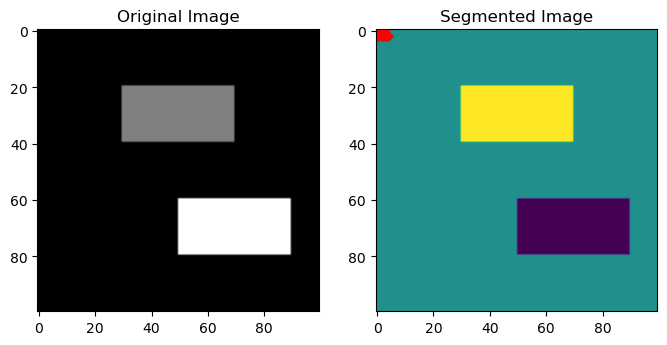

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pygad

# Generate synthetic grayscale image
image_size = (100, 100)
image = np.zeros(image_size)
image[20:40, 30:70] = 1
image[60:80, 50:90] = 2

# Flatten the image matrix
image_flat = image.flatten().reshape(-1, 1)

# Define the number of clusters (segments)
num_segments = 3

def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X - Y, 2), axis=1))


def segment_data(solution, solution_idx):
    global num_segments, image
    pixel_value_length = image_flat.shape[1]
    segment_centers = []
    all_segments_dists = []
    segments = []
    segments_sum_dist = []

    for seg_idx in range(num_segments):
        # Extract the coordinates (x, y) of the cluster center
        center_coordinates = solution[pixel_value_length * seg_idx:pixel_value_length * (seg_idx + 1)]
        segment_centers.append(center_coordinates)

        # Calculate the Euclidean distance from each pixel to the cluster center
        segment_center_dists = euclidean_distance(image_flat, center_coordinates)
        all_segments_dists.append(np.array(segment_center_dists))

    segment_centers = np.array(segment_centers)
    all_segments_dists = np.array(all_segments_dists)

    # Assign each pixel to the cluster with the closest center
    segment_indices = np.argmin(all_segments_dists, axis=0)

    for seg_idx in range(num_segments):
        segments.append(np.where(segment_indices == seg_idx)[0])
        if len(segments[seg_idx]) == 0:
            segments_sum_dist.append(0)
        else:
            segments_sum_dist.append(np.sum(all_segments_dists[seg_idx, segments[seg_idx]]))

    segments_sum_dist = np.array(segments_sum_dist)

    return segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist

def fitness_func(_, solution, solution_idx):
    _, _, _, _, segments_sum_dist = segment_data(solution, solution_idx)

    fitness = 1.0 / (np.sum(segments_sum_dist) + 0.00000001)

    return fitness

num_genes = num_segments * image_flat.shape[1]

ga_instance = pygad.GA(num_generations=100,
                       sol_per_pop=10,
                       num_parents_mating=5,
                       init_range_low=0,
                       init_range_high=1,
#                       gene_space= [image.shape[0], image.shape[1]],
                       keep_parents=2,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       suppress_warnings=True)

ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist = segment_data(best_solution, best_solution_idx)

# Reshape the segmented image to its original shape
final_segmentation = np.zeros_like(image)
for seg_idx in range(num_segments):
    final_segmentation.flat[segments[seg_idx]] = seg_idx + 1

# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
# Plot the cluster centers on the segmented image
for center_value in segment_centers:
    plt.scatter(center_value, 0, marker='X', s=200, c='red')
plt.imshow(final_segmentation, cmap='viridis')
plt.title('Segmented Image')

plt.show()


# Testing with different dataset

Import the MNIST dataset and try the same algorithm on 2 classes.